<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
import pandas as pd
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

C:\Users\Nick\AppData\Roaming\Python\Python37\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
data = pd.read_csv('./module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
print(data.shape)
data.head()

(28332, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [4]:
data['primaryCategories'].value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Electronics,Furniture              2
Home & Garden                      2
Name: primaryCategories, dtype: int64

In [86]:
df = data[['name', 'primaryCategories', 'reviews.text']].copy()
df.head()

,name,primaryCategories,reviews.text
0,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,I order 3 of them and one of the item is bad q...
1,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Bulk is always the less expensive way to go fo...
2,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Well they are not Duracell but for the price i...
3,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Seem to work as well as name brand batteries a...
4,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,These batteries are very long lasting the pric...


In [69]:
replacer = df[df['primaryCategories'] != 'Health & Beauty']['primaryCategories'].unique().tolist()
replacer

['Electronics',
 'Office Supplies',
 'Animals & Pet Supplies',
 'Home & Garden',
 'Electronics,Furniture',
 'Toys & Games,Electronics',
 'Electronics,Media',
 'Office Supplies,Electronics']

In [70]:
# Merge everything other than Health&Beauty to 'Electronics' (These category names aren't very accurate anyways!)
df['primaryCategories'] = df['primaryCategories'].replace([x for x in replacer], 'Electronics')
df['primaryCategories'].value_counts()

Electronics        16261
Health & Beauty    12071
Name: primaryCategories, dtype: int64

^^I'VE CHANGED MY MIND AND DON'T ACTUALLY WANT TO DO THIS

In [48]:
df = data[['name', 'reviews.text']].copy().set_index('name')
df.head()

,reviews.text
name,
AmazonBasics AAA Performance Alkaline Batteries (36 Count),I order 3 of them and one of the item is bad q...
AmazonBasics AAA Performance Alkaline Batteries (36 Count),Bulk is always the less expensive way to go fo...
AmazonBasics AAA Performance Alkaline Batteries (36 Count),Well they are not Duracell but for the price i...
AmazonBasics AAA Performance Alkaline Batteries (36 Count),Seem to work as well as name brand batteries a...
AmazonBasics AAA Performance Alkaline Batteries (36 Count),These batteries are very long lasting the pric...


## Let's tokenize and get lemmas!

In [9]:
from spacy.tokenizer import Tokenizer
import spacy

In [10]:
nlp = spacy.load('en_core_web_lg')
tokenizer = Tokenizer(nlp.vocab)

In [49]:
tokens = []
for i in tokenizer.pipe(df['reviews.text']):
    doc_tokens = []
    for token in i:
        if (token.is_stop != True) & (token.is_punct != True):
            doc_tokens.append(token.lemma_)
    tokens.append(doc_tokens)
df['lemmas'] = tokens
df.head()

,reviews.text,lemmas
name,,
AmazonBasics AAA Performance Alkaline Batteries (36 Count),I order 3 of them and one of the item is bad q...,"[order, 3, item, bad, quality., miss, backup, ..."
AmazonBasics AAA Performance Alkaline Batteries (36 Count),Bulk is always the less expensive way to go fo...,"[Bulk, expensive, way, product, like]"
AmazonBasics AAA Performance Alkaline Batteries (36 Count),Well they are not Duracell but for the price i...,"[Duracell, price, happy.]"
AmazonBasics AAA Performance Alkaline Batteries (36 Count),Seem to work as well as name brand batteries a...,"[work, brand, battery, well, price]"
AmazonBasics AAA Performance Alkaline Batteries (36 Count),These batteries are very long lasting the pric...,"[battery, long, last, price, great.]"


In [50]:
df['lemmas'][0]

['order',
 '3',
 'item',
 'bad',
 'quality.',
 'miss',
 'backup',
 'spring',
 'pcs',
 'aluminum',
 'battery',
 'work.']

### Let's do a quick word count to see if there are any other things we should add to the stop words

In [13]:
from collections import Counter
frequencies = Counter(word for sentence in df['lemmas'] for word in sentence)
# for word, frequency in frequencies.most_common(20):
#     print(word, frequency)
item = []
frequency = []
for i in range(20):
    item.append(frequencies.most_common()[i][0])
    frequency.append(frequencies.most_common()[i][1])
counts = pd.DataFrame({'items':item, 'frequency':frequency})

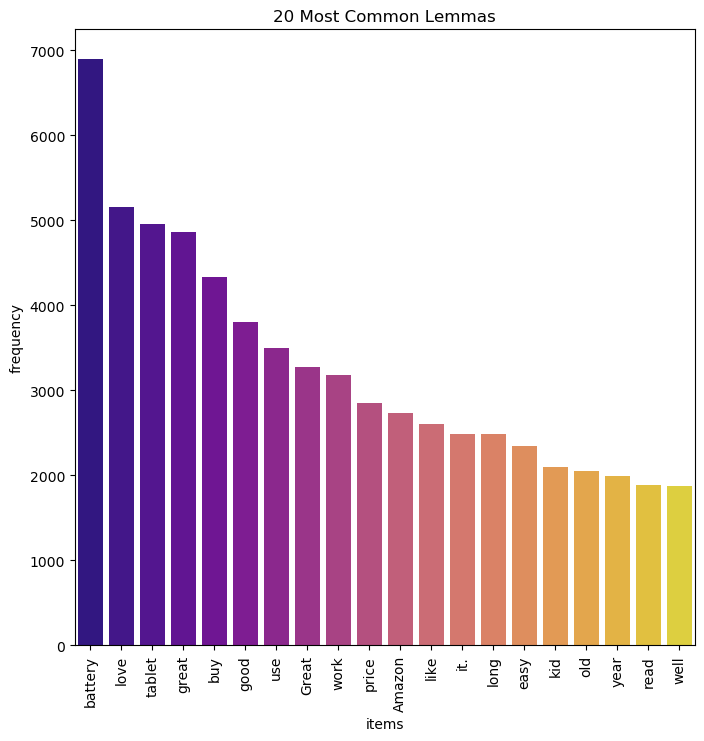

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.barplot(data=counts, x='items', y='frequency', palette='plasma')
    plt.xticks(rotation=90)
    ax.set_title('20 Most Common Lemmas')

Maybe a couple words that need to be removed, but there are probably 100's of words only used once...
let's remove them below

In [15]:
stop_adds = [i[0] for i in frequencies.most_common() if i[1] < 2]
len(stop_adds)

8573

Wasn't expecting 8500 words used only once! Let's see what they are

In [16]:
stop_adds

['pcs',
 'duracell,',
 'mixed-bag',
 '(inconsistent',
 'others).',
 "tank's",
 'Thankful',
 'crazy)',
 'Cameras',
 'beeding',
 'towels.',
 '(december)',
 '2months',
 'doorbell',
 'CHANCE',
 'HOPEFULLY',
 'REMAIN',
 'ORDER',
 'REASONABLE',
 'MEANING',
 'OUT.',
 'ok,it',
 'thanks..',
 'kno',
 'eeeks',
 'Energizer-',
 '2027.',
 'Ones',
 'Date',
 'Inedible.',
 'PACK,',
 'USEDD',
 'FASTER',
 'WOULD!!,SO',
 'quantity..',
 'tthrough',
 'while..',
 'DURACELL',
 'SAVES',
 'MONEY!',
 'WalMart.',
 'Jn',
 '(stored',
 'indoors).',
 'buck!!',
 'BLEW',
 'stockpile.',
 'Oprah.',
 'battery!...',
 'chuckle',
 "'primitive'",
 'integral',
 'lives.',
 'food,',
 'drink,',
 'shelter,',
 'price/quality',
 'combination.',
 'Thes',
 'xpected.',
 'account!',
 'LeapPads,',
 "those.I've",
 'quality/lifespan.',
 'DEFINTELY',
 'PS3',
 'teacher,',
 'excessive',
 'option!',
 'matters,',
 'lol)!',
 'stores!I',
 'long...a',
 'Lieutenant',
 '-Forrest',
 'namebrands,',
 "reviewer's",
 'she,',
 'remember)',
 'packaging.So'

Looks like many words that ended up with punctation or words that are mispelled/not real

In [17]:
# Create new list of stop words
# for some reason I can't just do stop_words.union(stop_adds)
STOPWORD = nlp.Defaults.stop_words.union(stop_adds[:8573]).union(['Amazon', 'it.'])
len(STOPWORD)

8895

In [18]:
tokens = []
for i in tokenizer.pipe(df['reviews.text']):
    doc_tokens = []
    for token in i:
        if (token.text not in STOPWORD) & (token.is_stop != True) & (token.is_punct != True):
            doc_tokens.append(token.lemma_)
    tokens.append(doc_tokens)
df['lemmas'] = tokens

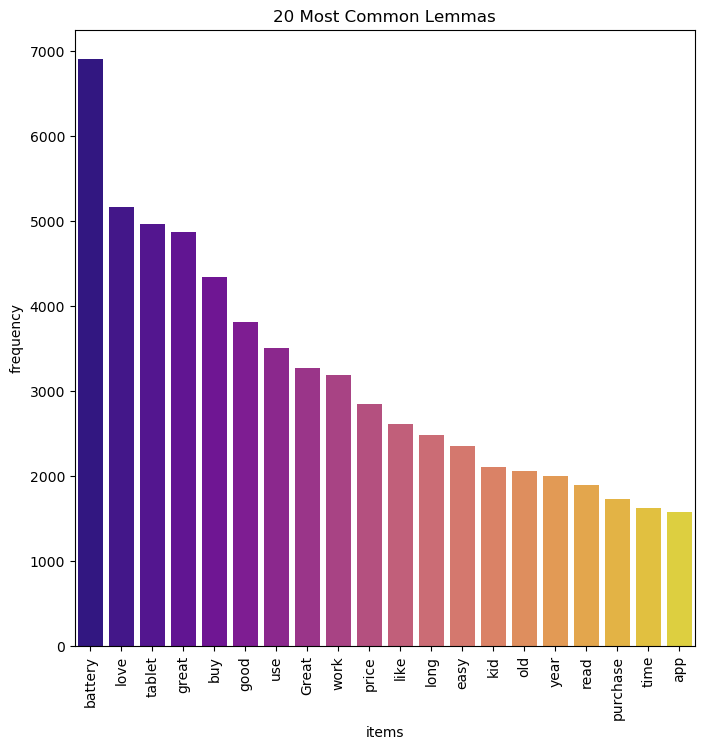

In [19]:
frequencies = Counter(word for sentence in df['lemmas'] for word in sentence)
item = []
frequency = []
for i in range(20):
    item.append(frequencies.most_common()[i][0])
    frequency.append(frequencies.most_common()[i][1])
counts = pd.DataFrame({'items':item, 'frequency':frequency})
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.barplot(data=counts, x='items', y='frequency', palette='plasma')
    plt.xticks(rotation=90)
    ax.set_title('20 Most Common Lemmas')

# Let's get to the assignment

In [20]:
id2word = corpora.Dictionary(df['lemmas'])

In [21]:
len(id2word.keys())

13538

## OMG THERE'S LITERALLY METHODS IN corpora.Dictionary TO DO WHAT I JUST DID!!

In [22]:
# Let's put all that back in and use the built in no_below
tokens = []
for i in tokenizer.pipe(df['reviews.text']):
    doc_tokens = []
    for token in i:
        if (token.is_stop != True) & (token.is_punct != True):
            doc_tokens.append(token.lemma_)
    tokens.append(doc_tokens)
df['lemmas'] = tokens

In [23]:
id2word = corpora.Dictionary(df['lemmas'])

In [24]:
len(id2word.keys())

21876

In [25]:
id2word.filter_extremes(no_below=2, no_above=0.98)
len(id2word.keys())

13206

In [26]:
corpus = [id2word.doc2bow(i) for i in df['lemmas']]

In [27]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state= 42,
                   num_topics = 4,
                   passes=10,
                   workers=8
                  )

In [28]:
lda.print_topics()

[(0,
  '0.039*"love" + 0.020*"year" + 0.019*"old" + 0.018*"buy" + 0.017*"it." + 0.014*"tablet" + 0.011*"great" + 0.009*"battery" + 0.008*"play" + 0.008*"2"'),
 (1,
  '0.031*"tablet" + 0.023*"great" + 0.015*"use" + 0.014*"kid" + 0.013*"read" + 0.013*"Great" + 0.013*"buy" + 0.010*"game" + 0.010*"app" + 0.009*"love"'),
 (2,
  '0.016*"easy" + 0.014*"use" + 0.014*"tablet" + 0.013*"love" + 0.011*"read" + 0.010*"like" + 0.010*"it." + 0.009*"great" + 0.009*"Kindle" + 0.008*"Amazon"'),
 (3,
  '0.044*"battery" + 0.023*"good" + 0.018*"work" + 0.016*"price" + 0.016*"long" + 0.015*"Great" + 0.013*"great" + 0.012*"buy" + 0.011*"batteries." + 0.011*"brand"')]

In [29]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
for id, t in enumerate(topics): 
    print(f'------Topic {id}------')
    print(t, end='\n\n')

------Topic 0------
love year old buy it.

------Topic 1------
tablet great use kid read

------Topic 2------
easy use tablet love read

------Topic 3------
battery good work price long



In [30]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

C:\Users\Nick\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.171978  0.013523       1        1  32.910721
2      0.066495  0.076046       2        1  24.384741
0      0.036877 -0.107599       3        1  24.363825
1      0.068606  0.018029       4        1  18.340706, topic_info=     Category         Freq        Term        Total  loglift  logprob
4     Default  5919.000000     battery  5919.000000  30.0000  30.0000
100   Default  5037.000000        love  5037.000000  29.0000  29.0000
114   Default  1929.000000        year  1929.000000  28.0000  28.0000
1225  Default  2029.000000         old  2029.000000  27.0000  27.0000
5564  Default  5276.000000      tablet  5276.000000  26.0000  26.0000
133   Default  1282.000000  batteries.  1282.000000  25.0000  25.0000
1207  Default  1896.000000        read  1896.000000  24.0000  24.0000
19    Default  1287.000000       brand  1287.000000  23.0000  23.0000
606   Default  2468.000000         it.  2468.000000  22.0000  22.0000
24    Default  2233.000000        long  2233.000000  21.0000  21.0000
3822  Default  1132.000000        book  1132.000000  20.0000  20.0000
203   Default  1314.000000        game  1314.000000  19.0000  19.0000
36    Default  2376.000000        easy  2376.000000  18.0000  18.0000
64    Default  3719.000000        good  3719.000000  17.0000  17.0000
212   Default  2121.000000         kid  2121.000000  16.0000  16.0000
611   Default  1445.000000        play  1445.000000  15.0000  15.0000
74    Default  4629.000000       great  4629.000000  14.0000  14.0000
6993  Default  1406.000000      Kindle  1406.000000  13.0000  13.0000
119   Default  3085.000000       Great  3085.000000  12.0000  12.0000
21    Default  3013.000000        work  3013.000000  11.0000  11.0000
204   Default  3444.000000         use  3444.000000  10.0000  10.0000
2695  Default  1629.000000         app  1629.000000   9.0000   9.0000
1221  Default   680.000000        fire   680.000000   8.0000   8.0000
18    Default  2714.000000       price  2714.000000   7.0000   7.0000
5057  Default   811.000000       watch   811.000000   6.0000   6.0000
1178  Default   931.000000     quality   931.000000   5.0000   5.0000
4309  Default  1005.000000      kindle  1005.000000   4.0000   4.0000
679   Default  1182.000000        Good  1182.000000   3.0000   3.0000
34    Default  4099.000000         buy  4099.000000   2.0000   2.0000
2983  Default  1176.000000      screen  1176.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
2695   Topic4   630.488220         app  1629.872803   0.7463  -4.6065
74     Topic4  1437.435181       great  4629.443848   0.5265  -3.7823
5134   Topic4   154.496490      games.   283.716858   1.0882  -6.0128
5626   Topic4    74.389755        inch   111.331802   1.2929  -6.7436
116    Topic4   484.356476        need  1358.480713   0.6647  -4.8701
611    Topic4   506.314758        play  1445.531494   0.6470  -4.8258
1558   Topic4   257.986420       learn   591.639221   0.8661  -5.5001
4481   Topic4   294.818176       enjoy   709.862366   0.8173  -5.3666
204    Topic4   947.270020         use  3444.368408   0.4051  -4.1994
119    Topic4   809.443298       Great  3085.720947   0.3579  -4.3566
7524   Topic4   151.566269       apps.   301.802612   1.0073  -6.0319
1640   Topic4   184.935303       video   411.941711   0.8952  -5.8330
22     Topic4   238.934738      great.   606.297974   0.7649  -5.5768
41     Topic4   331.150177         lot  1001.199097   0.5897  -5.2504
1745   Topic4   269.149872        Easy   740.999634   0.6833  -5.4577
34     Topic4   801.596680         buy  4099.105957   0.0641  -4.3664
190    Topic4   426.847565        time  1542.007935   0.4116  -4.9965
985    Topic4   270.002167        Love   755.208496   0.6675  -5.4545
6488   Topic4   263.889801    download   728.036133   0.6812  -5.4774
679    Topic4   342.039185        Good  1182.045898   0.4560  -

In [36]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,3)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]
len(new_distro)

28332

In [87]:
df1 = pd.DataFrame.from_records(new_distro, index=df['primaryCategories'])
df1.columns = topics
df1.reset_index().groupby('primaryCategories').mean()

,love year old buy it.,tablet great use kid read,easy use tablet love read,battery good work price long
primaryCategories,,,,
Animals & Pet Supplies,0.109925,0.041980,0.457537,0.390558
Electronics,0.302949,0.272829,0.283774,0.149233
"Electronics,Furniture",0.250824,0.016072,0.717268,0.015836
"Electronics,Media",0.175784,0.103724,0.611749,0.129289
Health & Beauty,0.105349,0.105461,0.088473,0.699729
Home & Garden,0.271143,0.251370,0.399879,0.077609
Office Supplies,0.059205,0.140211,0.499862,0.300722
"Office Supplies,Electronics",0.192437,0.205291,0.475438,0.134462
"Toys & Games,Electronics",0.493489,0.257182,0.151038,0.104903


## Using gensim Coherence Model

In [90]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    # tokens = list(doc_stream(path))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            # stream = doc_stream(path)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=8)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [92]:
# Can take a long time to run.
import warnings # remove deprecation warnings for each iteration
with warnings.catch_warnings():
  warnings.filterwarnings("ignore",category=DeprecationWarning)
  coherence_values = compute_coherence_values(dictionary=id2word,
                                              corpus=corpus, 
                                              start=2, 
                                              limit=40, 
                                              step=6,
                                              passes=40)

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling